# Drive & Environment Setting

In [1]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

from pkl import store_data, load_data
from functions.compressor import compress
from functions.compressor_param import compress_2

import random
from collections import defaultdict

import time



print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive


2023-05-08 01:37:25.908729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported


# Import Anagrafica e CTA

In [2]:
cta30_def_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')
CTA30_def = [cta30_def_path]
  
df_def = pd.read_csv(CTA30_def[0])

cta30_18_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
cta30_19_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
cta30_20_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
CTA30_18 = [cta30_18_path]
CTA30_19 = [cta30_19_path]
CTA30_20 = [cta30_20_path]

df18= pd.read_csv(CTA30_18[0])
df19= pd.read_csv(CTA30_19[0])
df20= pd.read_csv(CTA30_20[0])
df = pd.concat([df18, df19], ignore_index=True)

df['VLV_RAF_FDBK_00'] = df['VLV_RAF_FDBK_00'] / 100
df['VLV_SUR_FDBK_00'] = df['VLV_SUR_FDBK_00'] / 100

scaler = MinMaxScaler()
act_f_m = df.loc[:,'F_M_FDBK_00']
a_f_m_reshaped = np.array(act_f_m).reshape(-1, 1)
a_f_m_scaled = scaler.fit_transform(a_f_m_reshaped)

min_f = np.min(a_f_m_scaled)
max_f = np.max(a_f_m_scaled)

a_raf_df = df['VLV_RAF_FDBK_00'] * 0.5
a_sur_df = df['VLV_SUR_FDBK_00'] * 0.5 + 0.5

a_df = pd.concat([a_raf_df, a_sur_df], ignore_index=True)

pca_df = compress_2(df, 0.93)
print("df18 shape: ", df18.shape)
print("df19 shape: ", df19.shape)
[r,c] = df.shape
print("df shape: ", df.shape)
[r,n_components] = pca_df.shape
print("pca_df shape: ", pca_df.shape)

df18 shape:  (141811, 76)
df19 shape:  (523489, 76)
df shape:  (665300, 76)
pca_df shape:  (665300, 6)


Text(0.5, 0, 'PW_ATT_M_00')

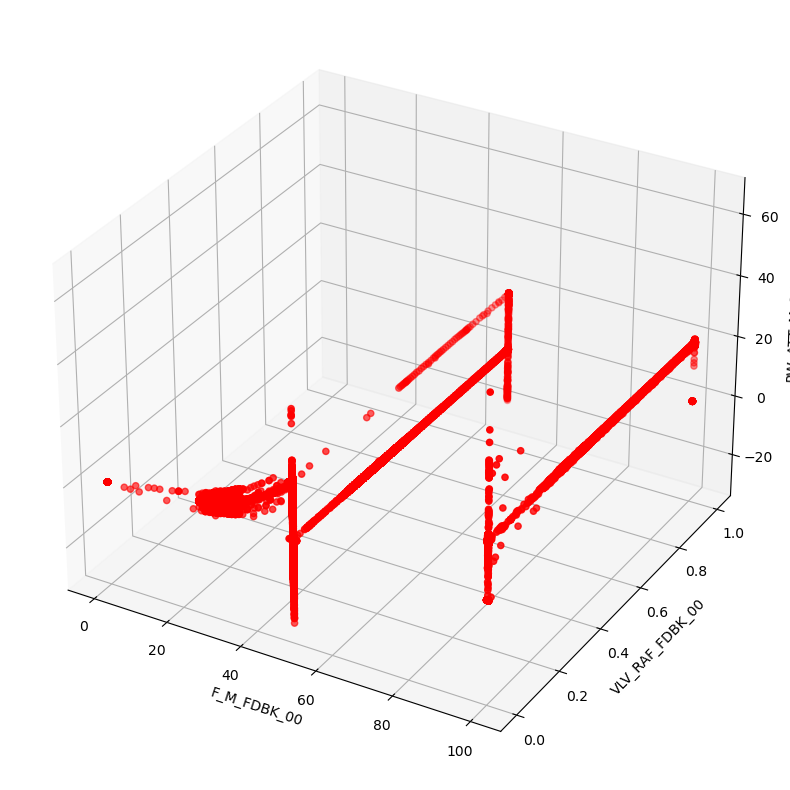

In [11]:
# plot on 3d graph F_M_FDBK_00, the concatenation of VLV_RAF_FDBK_00 and VLV_SUR_FDBK_00 and the PW_ATT_M_00

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['F_M_FDBK_00'], df['VLV_RAF_FDBK_00'], df['PW_ATT_M_00'], c='r', marker='o')

ax.set_xlabel('F_M_FDBK_00')
ax.set_ylabel('VLV_RAF_FDBK_00')
ax.set_zlabel('PW_ATT_M_00')

# Learning

### Rete Neurale 9 32 32 1   -   relu

In [11]:
n = load_data('_.pkl')
if IN_COLAB == True:
    n = load_data('*.pkl')

action_vector_dimension = 2

# Architettura rete neurale
input_dim = n['n_components'] + action_vector_dimension
inner_dim_1 = 32
inner_dim_2 = 32
output_dim = 1

print("input dim: ", input_dim)
print("inner layer1 dim: ", inner_dim_1)
print("inner layer2 dim: ", inner_dim_2)
print("output dim: ", output_dim)

# Definizione rete neurale
rete_neurale = Sequential()
rete_neurale.add(Dense(inner_dim_1, input_dim=input_dim, activation='relu'))
rete_neurale.add(Dense(inner_dim_2, input_dim=inner_dim_1, activation='relu'))
rete_neurale.add(Dense(output_dim, input_dim=inner_dim_2, activation='relu'))

adam = Adam(learning_rate=0.001)
rete_neurale.compile(loss='mse', optimizer=adam, metrics=['mae'])

rete_neurale.load_weights('DEFrete_neurale_DQN_32321_relu.h5')

# Definisco funzione obiettivo per la massimizzazione della predizione 
def objective(x, s_prime):
    pca_s_prime = pca_df.loc[s_prime,:]
    nn_input_prime = np.concatenate((pca_s_prime.values.reshape(7,1), x[0].reshape(1,1), x[1].reshape(1,1)), axis=0)
    nn_input_prime = np.reshape(nn_input_prime, (1,input_dim))
    funct = rete_neurale.predict(nn_input_prime, verbose=0)[0][0]
    return -funct

def are_weights_equal(w0, w1):
    # Verifica se le due liste hanno la stessa lunghezza
    if len(w0) != len(w1):
        return False
    
    # Verifica se gli elementi delle due liste sono uguali
    for i in range(len(w0)):
        if isinstance(w0[i], list) and isinstance(w1[i], list):
            # Se l'elemento corrente è una lista, richiama la funzione in modo ricorsivo
            if not are_weights_equal(w0[i], w1[i]):
                return False
        else:
            # Altrimenti, verifica se gli array NumPy sono uguali
            if not np.array_equal(w0[i], w1[i]):
                return False
    
    # Se tutte le verifiche precedenti sono state superate, le due liste sono uguali
    return True



input dim:  9
inner layer1 dim:  32
inner layer2 dim:  32
output dim:  1


In [10]:
[S, feat] = df.shape
current_state = 7328
s = current_state
current_episode = 0
total_episodes = 10000

bounds = [(min_f, max_f), (0,1)]

alpha = 0.5
gamma = 1

convergence = False
w0 = rete_neurale.get_weights()

while convergence == False:
  
  for current_episode in range(total_episodes):

      s_prime = s+1
      if s_prime > S-1:
        print("s =", s)
        break
      # a1 = frequenza sul motore di mandata
      a1 = df.loc[s,'F_M_FDBK_00']

      # a2 = percentuale di apertura delle valvole caldo/freddo (esclusive)
      a_raf = df.loc[s,'VLV_RAF_FDBK_00']
      a_sur = df.loc[s,'VLV_SUR_FDBK_00']
      if a_raf == 0:
        if a_sur == 0:
          a2 = 0
        else:
          a2 = a_sur_df[s]
      else:
        a2 = a_raf_df[s]
        
      a = (a1,a2)

      # r = reward 
      r = -df.loc[s,'PW_ATT_M_00']

      # Condizioni iniziali random per la minimizzazione
      #data_f = a_f_m_scaled
      #a0_f = data_f[np.random.randint(len(data_f))]
      #a0_v = np.random.rand()
      #x0 = [a0_f, a0_v]
    
      # Dominio della minimizzazione 
      print("minimizing...")
      start_time = time.time()
      # Risultato della minimizzazione
      objective_minimized = differential_evolution(objective, bounds=bounds, args=(s_prime,))
      end_time = time.time()
      print("time elapsed: ", end_time - start_time, "seconds")
    
      # Compongo input della predizione di q'
      a1_prime_input = np.array([objective_minimized.x[0]]).reshape(1,1)
      a2_prime_input = objective_minimized.x[1].reshape(1,1)
      s_prime_input = pca_df.loc[s_prime,:].values.reshape(7,1)
      conc1 = np.concatenate((s_prime_input, a1_prime_input), axis=0)
      a2_prime_input = np.expand_dims(a2_prime_input, axis=1).reshape(1,1)
      conc2 = np.concatenate((conc1, a2_prime_input), axis=0)
      nn_input_prime = np.reshape(conc2, (1,input_dim))
      # Compongo input della predizione di q
      a1_input = np.array([a1]).reshape(1,1)
      a2_input = np.array([a2]).reshape(1,1)
      s_input = pca_df.loc[s,:].values.reshape(7,1)
      conc1 = np.concatenate((s_input, a1_input), axis=0)
      a2_input = np.expand_dims(a2_input, axis=1).reshape(1,1)
      conc2 = np.concatenate((conc1, a2_input), axis=0)
      nn_input = np.reshape(conc2, (1,input_dim))

      # Predizione di q'
      q_prime = rete_neurale.predict(nn_input_prime, verbose = 0)[0]
      q_prime = q_prime[0]

      # Predizione di q
      q_ = rete_neurale.predict(nn_input, verbose = 0)[0] 
      q_ = q_[0]

      # q = avr + gamma*max(q')
      q = q_ + alpha*(r + gamma*q_prime - q_)
      
      #print("F_M_FDBK_00: ", df.iloc[s,'F_M_FDBK_00'])
      # Calcola il valore target per il training della rete neurale
      target = q
      target = np.array([target])

      # Aggiornamento della rete neurale
      rete_neurale.fit(nn_input, target, epochs=1, verbose=0)
      w1 = rete_neurale.get_weights()

      # Aggiornamento  dello stato corrente
      s = s_prime

      # Plot statistiche ogni n episodi    
      n_print = 5
      if current_episode%n_print == 0:
        print("\n")
        print("current_episode = ", current_episode)
        print("Episodio ",current_episode,"/",total_episodes)
        print("q: ", q)
        print("F_M_FDBK_00: ", df.loc[s,'F_M_FDBK_00'])
        print("VLV_RAF_FDBK_00: ", df.loc[s,'VLV_RAF_FDBK_00'])
        print("VLV_SUR_FDBK_00: ", df.loc[s,'VLV_SUR_FDBK_00'])
        print("\n")
        rete_neurale.save_weights('rete_neurale_DQN_32321_relu.h5')

      # Convergenza
      if are_weights_equal(w0, w1) == True:
        convergence = True
        print("Convergenza raggiunta")
        rete_neurale.save_weights('DEFrete_neurale_DQN_32321_relu.h5')
        break



 




minimizing...
time elapsed:  79.68677282333374 seconds


current_episode =  0
Episodio  0 / 10000
q:  0.03239952027797699
F_M_FDBK_00:  100.0062
VLV_RAF_FDBK_00:  0.0
VLV_SUR_FDBK_00:  0.0


Convergenza raggiunta


In [103]:
objective_minimized = differential_evolution(objective, bounds=bounds)

In [104]:
objective_minimized.x

array([1.62224373e-04, 9.99985037e-01])

In [105]:
print("a1: ", objective_minimized.x[0])
print("a2: ", objective_minimized.x[1])

a1:  0.00016222437298824
a2:  0.9999850373753563


In [113]:
s_random = [0, 25, 2984, 459000, 657, 372122, 600000]
s_random = sorted(s_random)
my_list = []

for s in s_random:
    objective_minimized = differential_evolution(objective, bounds=bounds, args=(s,))
    a1 = np.array([objective_minimized.x[0]]).reshape(1,1)
    a2 = np.array([objective_minimized.x[1]]).reshape(1,1)
    pca_s = pca_df.loc[s,:]
    nn_input = np.concatenate((pca_s.values.reshape(7,1), a1, a2), axis=0)
    nn_input = np.reshape(nn_input, (1,input_dim))
    funct = rete_neurale.predict(nn_input, verbose=0)[0][0]

    dict = {'s': s, 'a1': a1, 'a2': a2, 'funct': funct}
    my_list.append(dict)
    
    print("s: ", s)
    print("a1: ", a1)
    print("a2: ", a2)
    print("funct: ", funct)
    print("\n")


s:  0
a1:  [[0.99998868]]
a2:  [[0.99812511]]
funct:  0.06457686


s:  25
a1:  [[0.99995811]]
a2:  [[0.98375849]]
funct:  0.06424554


s:  657
a1:  [[0.99931665]]
a2:  [[0.99800862]]
funct:  0.061837643


s:  2984
a1:  [[0.99998881]]
a2:  [[0.99801689]]
funct:  0.061697394


s:  372122
a1:  [[0.99999804]]
a2:  [[0.45752592]]
funct:  0.07155414


s:  459000
a1:  [[0.00982029]]
a2:  [[0.84830029]]
funct:  0.05942191


s:  600000
a1:  [[0.99730086]]
a2:  [[0.00759291]]
funct:  0.14788482




In [111]:
print("a1: ", objective_minimized.x[0])
print("a2: ", objective_minimized.x[1])

a1:  0.0006618410383403828
a2:  0.9983449630398374


In [14]:
n = load_data('_.pkl')
if IN_COLAB == True:
    n = load_data('*.pkl')

action_vector_dimension = 2

# Architettura rete neurale
input_dim = n['n_components'] + action_vector_dimension
inner_dim_1 = 64
inner_dim_2 = 64
output_dim = 1

print("input dim: ", input_dim)
print("inner layer1 dim: ", inner_dim_1)
print("inner layer2 dim: ", inner_dim_2)
print("output dim: ", output_dim)

# Definizione rete neurale
rete_neurale_1 = Sequential()
rete_neurale_1.add(Dense(inner_dim_1, input_dim=input_dim, activation='relu'))
rete_neurale_1.add(Dense(inner_dim_2, input_dim=inner_dim_1, activation='relu'))
rete_neurale_1.add(Dense(output_dim, input_dim=inner_dim_2, activation='relu'))

adam = Adam(learning_rate=0.001)
rete_neurale_1.compile(loss='mse', optimizer=adam, metrics=['mae'])

rete_neurale_1.load_weights('rete_neurale_DQN_64641_relu.h5')

# Definisco funzione obiettivo per la massimizzazione della predizione 
def objective(x, s_prime):
    pca_s_prime = pca_df.loc[s_prime,:]
    nn_input_prime = np.concatenate((pca_s_prime.values.reshape(7,1), x[0].reshape(1,1), x[1].reshape(1,1)), axis=0)
    nn_input_prime = np.reshape(nn_input_prime, (1,input_dim))
    funct = rete_neurale_1.predict(nn_input_prime, verbose=0)[0][0]
    return -funct

def are_weights_equal(w0, w1):
    # Verifica se le due liste hanno la stessa lunghezza
    if len(w0) != len(w1):
        return False
    
    # Verifica se gli elementi delle due liste sono uguali
    for i in range(len(w0)):
        if isinstance(w0[i], list) and isinstance(w1[i], list):
            # Se l'elemento corrente è una lista, richiama la funzione in modo ricorsivo
            if not are_weights_equal(w0[i], w1[i]):
                return False
        else:
            # Altrimenti, verifica se gli array NumPy sono uguali
            if not np.array_equal(w0[i], w1[i]):
                return False
    
    # Se tutte le verifiche precedenti sono state superate, le due liste sono uguali
    return True



input dim:  9
inner layer1 dim:  64
inner layer2 dim:  64
output dim:  1


In [16]:
[S, feat] = df.shape
current_state = 7328
s = current_state
current_episode = 0
total_episodes = 10000

bounds = [(min_f, max_f), (0,1)]

alpha = 0.5
gamma = 1

convergence = False
w0 = rete_neurale_1.get_weights()

while convergence == False:
  
  for current_episode in range(total_episodes):

      s_prime = s+1
      if s_prime > S-1:
        print("s =", s)
        break
      # a1 = frequenza sul motore di mandata
      a1 = df.loc[s,'F_M_FDBK_00']

      # a2 = percentuale di apertura delle valvole caldo/freddo (esclusive)
      a_raf = df.loc[s,'VLV_RAF_FDBK_00']
      a_sur = df.loc[s,'VLV_SUR_FDBK_00']
      if a_raf == 0:
        if a_sur == 0:
          a2 = 0
        else:
          a2 = a_sur_df[s]
      else:
        a2 = a_raf_df[s]
        
      a = (a1,a2)

      # r = reward 
      r = -df.loc[s,'PW_ATT_M_00']

      # Condizioni iniziali random per la minimizzazione
      #data_f = a_f_m_scaled
      #a0_f = data_f[np.random.randint(len(data_f))]
      #a0_v = np.random.rand()
      #x0 = [a0_f, a0_v]
    
      # Dominio della minimizzazione 
      print("minimizing...")
      start_time = time.time()
      # Risultato della minimizzazione
      objective_minimized = differential_evolution(objective, bounds=bounds, args=(s_prime,))
      end_time = time.time()
      print("time elapsed: ", end_time - start_time, "seconds")
    
      # Compongo input della predizione di q'
      a1_prime_input = np.array([objective_minimized.x[0]]).reshape(1,1)
      a2_prime_input = objective_minimized.x[1].reshape(1,1)
      s_prime_input = pca_df.loc[s_prime,:].values.reshape(7,1)
      conc1 = np.concatenate((s_prime_input, a1_prime_input), axis=0)
      a2_prime_input = np.expand_dims(a2_prime_input, axis=1).reshape(1,1)
      conc2 = np.concatenate((conc1, a2_prime_input), axis=0)
      nn_input_prime = np.reshape(conc2, (1,input_dim))
      # Compongo input della predizione di q
      a1_input = np.array([a1]).reshape(1,1)
      a2_input = np.array([a2]).reshape(1,1)
      s_input = pca_df.loc[s,:].values.reshape(7,1)
      conc1 = np.concatenate((s_input, a1_input), axis=0)
      a2_input = np.expand_dims(a2_input, axis=1).reshape(1,1)
      conc2 = np.concatenate((conc1, a2_input), axis=0)
      nn_input = np.reshape(conc2, (1,input_dim))

      # Predizione di q'
      q_prime = rete_neurale_1.predict(nn_input_prime, verbose = 0)[0]
      q_prime = q_prime[0]

      # Predizione di q
      q_ = rete_neurale_1.predict(nn_input, verbose = 0)[0] 
      q_ = q_[0]

      # q = avr + gamma*max(q')
      q = q_ + alpha*(r + gamma*q_prime - q_)
      
      #print("F_M_FDBK_00: ", df.iloc[s,'F_M_FDBK_00'])
      # Calcola il valore target per il training della rete neurale
      target = q
      target = np.array([target])

      # Aggiornamento della rete neurale
      rete_neurale_1.fit(nn_input, target, epochs=1, verbose=0)
      w1 = rete_neurale_1.get_weights()

      # Aggiornamento  dello stato corrente
      s = s_prime

      # Plot statistiche ogni n episodi    
      n_print = 5
      if current_episode%n_print == 0:
        print("\n")
        print("current_episode = ", current_episode)
        print("Episodio ",current_episode,"/",total_episodes)
        print("q: ", q)
        print("F_M_FDBK_00: ", df.loc[s,'F_M_FDBK_00'])
        print("VLV_RAF_FDBK_00: ", df.loc[s,'VLV_RAF_FDBK_00'])
        print("VLV_SUR_FDBK_00: ", df.loc[s,'VLV_SUR_FDBK_00'])
        print("\n")
        rete_neurale_1.save_weights('rete_neurale_DQN_64641_relu.h5')

      # Convergenza
      if are_weights_equal(w0, w1) == True:
        convergence = True
        print("Convergenza raggiunta")
        rete_neurale_1.save_weights('DEFrete_neurale_DQN_64641_relu.h5')
        break



 




minimizing...
time elapsed:  53.04737401008606 seconds


current_episode =  0
Episodio  0 / 10000
q:  0.07338263094425201
F_M_FDBK_00:  100.0062
VLV_RAF_FDBK_00:  0.0
VLV_SUR_FDBK_00:  0.0


Convergenza raggiunta


## Multiple choice NN

In [3]:
def tansig(x):
    return 2 * tf.keras.activations.sigmoid(2 * x) - 1

tansig_activation = Activation(tansig)

In [4]:
n = load_data('_.pkl')
if IN_COLAB == True:
    n = load_data('*.pkl')

action_vector_dimension = 2

# Architettura rete neurale
input_dim = n_components + action_vector_dimension
output_dim = 1

# Definizione rete neurale 0
rete_neurale = Sequential()
inner_dim_1 = 32
rete_neurale.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
rete_neurale.add(Dense(output_dim, input_dim=inner_dim_1, activation=tansig_activation))

# Definizione rete neurale 1
inner_dim_1 = 12
rete_neurale_1 = Sequential()
rete_neurale_1.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
rete_neurale_1.add(Dense(output_dim, input_dim=inner_dim_1, activation=tansig_activation))

# Definizione rete neurale 2
inner_dim_1 = 32
inner_dim_2 = 32
rete_neurale_2 = Sequential()
rete_neurale_2.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
rete_neurale_2.add(Dense(inner_dim_2, input_dim=inner_dim_1, activation=tansig_activation))
rete_neurale_2.add(Dense(output_dim, input_dim=inner_dim_2, activation=tansig_activation))

# Definizione rete neurale 3
inner_dim_1 = 128
rete_neurale_3 = Sequential()
rete_neurale_3.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
rete_neurale_3.add(Dense(output_dim, input_dim=inner_dim_1, activation=tansig_activation))

# Definizione rete neurale 4
inner_dim = 256
rete_neurale_4 = Sequential()
rete_neurale_4.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
rete_neurale_4.add(Dense(output_dim, input_dim=inner_dim, activation=tansig_activation))



adam = Adam(learning_rate=0.001)
rete_neurale.compile(loss='mse', optimizer=adam, metrics=['mae'])
rete_neurale_1.compile(loss='mse', optimizer=adam, metrics=['mae'])
rete_neurale_2.compile(loss='mse', optimizer=adam, metrics=['mae'])
rete_neurale_3.compile(loss='mse', optimizer=adam, metrics=['mae'])
rete_neurale_4.compile(loss='mse', optimizer=adam, metrics=['mae'])

NN = [rete_neurale_1, rete_neurale, rete_neurale_2, rete_neurale_3, rete_neurale_4]
names = ['rete_neurale_1', 'rete_neurale', 'rete_neurale_2', 'rete_neurale_3', 'rete_neurale_4']


# Definisco funzione obiettivo per la massimizzazione della predizione 
def objective(x, s_prime, rete_neurale, n_components):
    pca_s_prime = pca_df.loc[s_prime,:]
    nn_input_prime = np.concatenate((pca_s_prime.values.reshape(n_components,1), x[0].reshape(1,1), x[1].reshape(1,1)), axis=0)
    nn_input_prime = np.reshape(nn_input_prime, (1,input_dim))
    funct = rete_neurale.predict(nn_input_prime, verbose=0)[0][0]
    return -funct

def are_weights_equal(w0, w1):
    # Verifica se le due liste hanno la stessa lunghezza
    if len(w0) != len(w1):
        return False
    
    # Verifica se gli elementi delle due liste sono uguali
    for i in range(len(w0)):
        if isinstance(w0[i], list) and isinstance(w1[i], list):
            # Se l'elemento corrente è una lista, richiama la funzione in modo ricorsivo
            if not are_weights_equal(w0[i], w1[i]):
                return False
        else:
            # Altrimenti, verifica se gli array NumPy sono uguali
            if not np.array_equal(w0[i], w1[i]):
                return False
    
    # Se tutte le verifiche precedenti sono state superate, le due liste sono uguali
    return True

2023-05-08 01:37:54.594484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
[S, feat] = df.shape
current_state = 126138
s = current_state
current_episode = 0
total_episodes = 10000

bounds = [(min_f, max_f), (0,1)]

alpha = 0.5
gamma = 1

convergence = False

for nn in NN:

    print("NN: ", names[NN.index(nn)])

    try:
        nn.load_weights('DQN_'+names[NN.index(nn)]+'_tansig_'+str(n_components)+'input.h5')
        print("try")
    except:
        print("except")
        pass

    w0 = nn.get_weights()

    while convergence == False:
    
        for current_episode in range(total_episodes):

            s_prime = s+1
            if s_prime > S-1:
                print("s =", s)
                break
            # a1 = frequenza sul motore di mandata
            #a1 = df.loc[s,'F_M_FDBK_00']
            a1 = a_f_m_scaled[s]

            # a2 = percentuale di apertura delle valvole caldo/freddo (esclusive)
            a_raf = df.loc[s,'VLV_RAF_FDBK_00']
            a_sur = df.loc[s,'VLV_SUR_FDBK_00']
            if a_raf == 0:
                if a_sur == 0:
                    a2 = 0
                else:
                    a2 = a_sur_df[s]
            else:
                a2 = a_raf_df[s]
                
            a = (a1,a2)

            # r = reward 
            r = -df.loc[s,'PW_ATT_M_00']

            
            
            # Minimizzazione della -NN per predizione di q' per ottenere a' (a1', a2')
            print("minimizing...")
            x0 = np.array(a).reshape(2,)
            print("x0: ", x0)
            start_time = time.time()
            objective_minimized = differential_evolution(objective, bounds=bounds, args=(s_prime,nn,n_components,), x0=x0, maxiter=300, tol=0.01, polish=True)
            end_time = time.time()
            print("time elapsed: ", end_time - start_time, "seconds")
            
            # Compongo input della predizione di q'
            a1_prime_input = np.array([objective_minimized.x[0]]).reshape(1,1)
            a2_prime_input = objective_minimized.x[1].reshape(1,1)
            s_prime_input = pca_df.loc[s_prime,:].values.reshape(n_components,1)
            conc1 = np.concatenate((s_prime_input, a1_prime_input), axis=0)
            a2_prime_input = np.expand_dims(a2_prime_input, axis=1).reshape(1,1)
            conc2 = np.concatenate((conc1, a2_prime_input), axis=0)
            nn_input_prime = np.reshape(conc2, (1,input_dim))
            # Compongo input della predizione di q
            a1_input = np.array([a1]).reshape(1,1)
            a2_input = np.array([a2]).reshape(1,1)
            s_input = pca_df.loc[s,:].values.reshape(n_components,1)
            conc1 = np.concatenate((s_input, a1_input), axis=0)
            a2_input = np.expand_dims(a2_input, axis=1).reshape(1,1)
            conc2 = np.concatenate((conc1, a2_input), axis=0)
            nn_input = np.reshape(conc2, (1,input_dim))

            # Predizione di q'
            q_prime = nn.predict(nn_input_prime, verbose = 0)[0]
            q_prime = q_prime[0]

            # Predizione di q
            q_ = nn.predict(nn_input, verbose = 0)[0] 
            q_ = q_[0]

            # q = avr + gamma*max(q')
            q = q_ + alpha*(r + gamma*q_prime - q_)
            
            # Calcola il valore target per il training della rete neurale
            target = q
            target = np.array([target])

            # Aggiornamento della rete neurale
            nn.fit(nn_input, target, epochs=1, verbose=0)
            w1 = nn.get_weights()

            # Aggiornamento  dello stato corrente
            s = s_prime

            # Plot statistiche ogni n episodi    
            n_print = 5
            if current_episode%n_print == 0:
                print("\n")
                print("current_episode = ", current_episode)
                print("Episodio ",current_episode,"/",total_episodes)
                print("q: ", q)
                print("F_M_FDBK_00: ", df.loc[s,'F_M_FDBK_00'])
                print("VLV_RAF_FDBK_00: ", df.loc[s,'VLV_RAF_FDBK_00'])
                print("VLV_SUR_FDBK_00: ", df.loc[s,'VLV_SUR_FDBK_00'])
                print("\n")
                string = ['DQN_',names[NN.index(nn)],'_tansig_'+str(n_components)+'input.h5']
                string = ''.join(string)
                nn.save_weights(string)

            # Convergenza
            if are_weights_equal(w0, w1) == True:
                print("####### w0 \n", w0)
                print("####### w1 \n", w1)
                convergence = True
                print("Convergenza raggiunta")
                string = ['DEF_DQN_',names[NN.index(nn)],'_tansig_'+str(n_components)+'input.h5']
                string = ''.join(string)
                nn.save_weights(string)
                



 




NN:  rete_neurale_1
try
minimizing...
x0:  [array([0.99638028]) 0]
time elapsed:  15.949352025985718 seconds


current_episode =  0
Episodio  0 / 10000
q:  0.93507319688797
F_M_FDBK_00:  99.993
VLV_RAF_FDBK_00:  0.0
VLV_SUR_FDBK_00:  0.0


minimizing...
x0:  [array([0.9965497]) 0]
time elapsed:  15.455230236053467 seconds
minimizing...
x0:  [array([0.99627264]) 0]
time elapsed:  20.95060396194458 seconds
minimizing...
x0:  [array([0.99618693]) 0]
time elapsed:  15.786419868469238 seconds
minimizing...
x0:  [array([0.99632845]) 0]
time elapsed:  18.4048912525177 seconds
minimizing...
x0:  [array([0.99608329]) 0]
time elapsed:  23.197935819625854 seconds


current_episode =  5
Episodio  5 / 10000
q:  0.9507365822792053
F_M_FDBK_00:  99.9738
VLV_RAF_FDBK_00:  0.0
VLV_SUR_FDBK_00:  0.0


minimizing...
x0:  [array([0.99635835]) 0]
time elapsed:  23.001340866088867 seconds
minimizing...
x0:  [array([0.99649589]) 0]
time elapsed:  27.321352243423462 seconds
minimizing...
x0:  [array([0.996172